###  House Prices: Advanced Regression Techniques
#### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.
#### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

#### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import (detect_outliers,one_hot_dataframe)
from datatools.dfloader import DataFrameLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 

% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
#colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

#sns.set_palette(sns.color_palette(colors))

#### Helper functions defined 

In [2]:
def plot_dataset(dataset,features ,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)

   
    for subplot_index ,i in enumerate(range(0,len(features))):
        if(features[i] != response_column ):
            ax = fig.add_subplot(3, 4,  subplot_index + 1)
            if log:
                ax.set(xscale="log",yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.regplot(x=features[i],y= response_column , marker="+", data = dataset,ax=ax)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            plt.tight_layout()
 
    plt.show()

In [3]:
def check_null(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    print("<{0} {1} {0}>".format("="*35,"Dataset null value count"))
    print(null_sum.sort_values(ascending=False))

In [4]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

---
#### Mainline

In [5]:
load_app_config()
DIRECTORY="kaggle_housing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'SalePrice'
input_path = get_datafolder_path()

train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
print(train_file)
print(test_file)



Adding D:\DataSource  to system path
Adding D:\MachineLearning  to system path
D:\DataSource\kaggle_housing\train.csv
D:\DataSource\kaggle_housing\test.csv


In [6]:
train_loader = DataFrameLoader(train_file, sep=',',header=0 ,encoding='utf8')
test_loader  = DataFrameLoader(test_file, sep=',',header=0 ,encoding='utf8')
 
#features  = [column for column in train_loader.dataframe.columns.values if column != RESPONSE]

X_train =train_loader.dataframe 
y_train =train_loader.dataframe[[RESPONSE]]
X_test = test_loader.dataframe 
y_train.describe()

,SalePrice
count,1460.0000
mean,180921.1959
std,79442.5029
min,34900.0000
25%,129975.0000
50%,163000.0000
75%,214000.0000
max,755000.0000


In [7]:
# Default continuous and categorical features
X_train_continuous = train_loader.continuous_dataframe
X_test_continuous = test_loader.continuous_dataframe
X_train_categorical = train_loader.categorical_dataframe
X_test_categorical = test_loader.categorical_dataframe


In [8]:
print(X_train.shape)
print(X_test.shape)

(1460, 81)
(1459, 80)


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


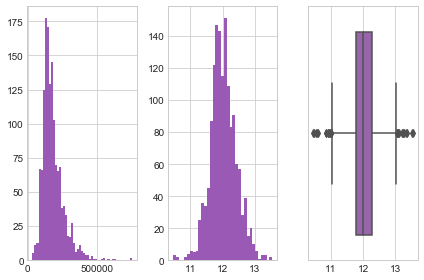

In [9]:
#log transformed SalePrice histogram  and boxplot - looks much like normal distribution now. 

fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(1,3, 1)
sns.distplot(X_train_continuous[[RESPONSE]],ax=ax1 ,kde =False,hist_kws=dict(alpha=1))
ax2 = fig.add_subplot(1,3, 2)
sns.distplot(np.log1p(X_train_continuous[[RESPONSE]]),ax=ax2 ,kde =False,hist_kws=dict(alpha=1))
ax3 = fig.add_subplot(1,3, 3)
sns.boxplot(x=np.log1p(X_train_continuous[[RESPONSE]]),ax=ax3)
plt.tight_layout()
plt.show()

In [10]:
ordinal_category =['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

In [11]:
continuous_features = [ feature for feature in train_loader.continuous_features if feature not in ordinal_category]
categorical_features = train_loader.categorical_features
categorical_features.extend(ordinal_category)
#continuous_features.remove('Id') ### we will drop it later we require it for analysis 
### SalePrice is not existing in test set 
continuous_features  =[feature for feature in continuous_features if feature !=RESPONSE]

In [12]:
print("size of categorical features :{}".format(len(categorical_features)))
print("size of continuous  features :{}".format(len(continuous_features)))

X_train_continuous = train_loader.dataframe[continuous_features]
check_null(X_train_continuous)

X_test_continuous = test_loader.dataframe[continuous_features]
check_null(X_test_continuous)
X_train[continuous_features].head()

size of categorical features :51
size of continuous  features :29
<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0
1,2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0
2,3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0
3,4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0
4,5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0


---
### Cleaning Datasets
#### Identifying missing values in data
#### Imputing (filling in) these missing values
#### Normalizing/standardizing data
---

In [13]:
X_train[continuous_features].iloc[:,0:10].head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF
0,1,65.0,8450,196.0,706,0,150,856,856,854
1,2,80.0,9600,0.0,978,0,284,1262,1262,0
2,3,68.0,11250,162.0,486,0,434,920,920,866
3,4,60.0,9550,0.0,216,0,540,756,961,756
4,5,84.0,14260,350.0,655,0,490,1145,1145,1053


In [14]:
X_train[continuous_features].iloc[:,0:10].describe()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF
count,1460.00,1201.0000,1460.0000,1452.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000
mean,730.50,70.0500,10516.8281,103.6853,443.6397,46.5493,567.2404,1057.4295,1162.6267,346.9925
std,421.61,24.2848,9981.2649,181.0662,456.0981,161.3193,441.8670,438.7053,386.5877,436.5284
min,1.00,21.0000,1300.0000,0.0000,0.0000,0.0000,0.0000,0.0000,334.0000,0.0000
25%,365.75,59.0000,7553.5000,0.0000,0.0000,0.0000,223.0000,795.7500,882.0000,0.0000
50%,730.50,69.0000,9478.5000,0.0000,383.5000,0.0000,477.5000,991.5000,1087.0000,0.0000
75%,1095.25,80.0000,11601.5000,166.0000,712.2500,0.0000,808.0000,1298.2500,1391.2500,728.0000
max,1460.00,313.0000,215245.0000,1600.0000,5644.0000,1474.0000,2336.0000,6110.0000,4692.0000,2065.0000


#### Inferences
###### OverallQual,OverallCond  are ordinal columns
###### MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF ,TotalBsmtSF have minimum value as  zero - Need to verify
###### TotalBsmtSF =BsmtFinSF1 +BsmtFinSF2 + BsmtUnfSF   
###### LotArea ,LotFrontage ,MasVnrArea,TotalBsmtSF   has linear relation with SalePrice. However  these values need to be log transformed  to re-evaluvate


In [15]:
#plot_dataset(X_train_continuous,RESPONSE,0,12,log=True)

In [16]:
X_train[continuous_features].iloc[:,10:20].head()

,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces
0,0,1710,1,0,2,1,3,1,8,0
1,0,1262,0,1,2,0,3,1,6,1
2,0,1786,1,0,2,1,3,1,6,1
3,0,1717,1,0,1,0,3,1,7,1
4,0,2198,1,0,2,1,4,1,9,1


In [17]:
X_train[continuous_features].iloc[:,20:].head()

,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,2,548,0,61,0,0,0,0,0
1,2,460,298,0,0,0,0,0,0
2,2,608,0,42,0,0,0,0,0
3,3,642,0,35,272,0,0,0,0
4,3,836,192,84,0,0,0,0,0


#### Inferences
##### GarageArea ,WoodDeckSF has linear relation with SalePrice  However  these values need to be log transformed  to re-evaluvate

In [18]:
check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageQual        81
GarageFinish      81
GarageType        81
GarageCond        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64
<=================================== Dataset null value count ===================================>
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MSZoning           4
Utilities          2
Functional         2
SaleType           1
Exterior2nd 

##### Categorical features  having "NA"  need not be considered as missing values.


In [19]:
## 'MasVnrType' NA - is same as None

NA_mapping ={'PoolQC':'No Pool','MiscFeature':'No MiscFeature','Alley':'No Alley',
'Fence':'No Fence','FireplaceQu':'No Fireplace ','GarageYrBlt':-1,
'GarageCond':'No Garage','GarageQual':'No Garage','GarageFinish':'No Garage',
'GarageType':'No Garage','BsmtCond':'No Basement','BsmtQual':'No Basement',
'BsmtExposure':'No Basement','BsmtFinType2':'No Basement','BsmtFinType1':'No Basement' ,
'MasVnrType':'None'
}

for feature in NA_mapping.keys():
    default_value  = NA_mapping.get(feature)
    X_train[feature].fillna(default_value,inplace = True)
    X_test[feature].fillna(default_value,inplace = True)
    
        

In [20]:
check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
Electrical    1
dtype: int64
<=================================== Dataset null value count ===================================>
MSZoning       4
Functional     2
Utilities      2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
dtype: int64


In [21]:
X_train[X_train['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2008,WD,Normal,167500


In [22]:
X_test[X_test['MSZoning'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,No Fireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,No Pool,No Fence,No MiscFeature,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,No Alley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,No Fireplace,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,No Alley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,No Fireplace,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,No Fireplace,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2006,WD,Normal


In [23]:
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts()) 
X_train['Neighborhood'].fillna('RM',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts())
X_train['Neighborhood'].fillna('RM',inplace = True)

### Timber neighborhood has SBrkr as electrical system.
print(X_train[X_train['Neighborhood'] == 'Timber']['Electrical'].value_counts()) 
X_train['Electrical'].fillna('SBrkr',inplace = True)

RM         40
C (all)    13
Name: MSZoning, dtype: int64
RM         28
C (all)     9
Name: MSZoning, dtype: int64
SBrkr    36
FuseA     1
Name: Electrical, dtype: int64


In [24]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
X_test['Functional'].fillna('Typ',inplace = True)
X_test[X_test['Functional'].isnull()]

Typ     35
Maj2     1
Mod      1
Name: Functional, dtype: int64
Typ     44
Min1     3
Min2     3
Mod      2
Maj1     1
Maj2     1
Name: Functional, dtype: int64


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [25]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts())
print(X_train[X_train['Neighborhood'] == 'Gilbert']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'Gilbert']['Utilities'].value_counts())
X_test[X_test['Utilities'].isnull()]
X_test['Utilities'].fillna('AllPub',inplace = True)

AllPub    37
Name: Utilities, dtype: int64
AllPub    55
Name: Utilities, dtype: int64
AllPub    79
Name: Utilities, dtype: int64
AllPub    85
Name: Utilities, dtype: int64


In [26]:
X_test[X_test['SaleType'].isnull()]
print(X_test[X_test['Neighborhood'] == 'Sawyer']['SaleType'].value_counts())
X_test['SaleType'].fillna('WD',inplace = True)

WD     72
COD     3
Oth     1
Name: SaleType, dtype: int64


In [27]:
X_test[X_test['KitchenQual'].isnull()]
print(X_test[X_test['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
print(X_train[X_train['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
X_test['KitchenQual'].fillna('TA',inplace = True)

TA    10
Gd     5
Name: KitchenQual, dtype: int64
TA    14
Gd    12
Ex     2
Name: KitchenQual, dtype: int64


In [28]:
X_test[ (X_test['Neighborhood'] == 'Edwards') & 
                    (X_test['RoofStyle'] == 'Flat') ][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN
1399,Plywood,Wd Shng


In [29]:
X_train[ (X_train['Neighborhood'] == 'Edwards') & 
                    (X_train['RoofStyle'] == 'Flat')&
                    (X_train['HouseStyle'] == '1Story')][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
1000,BrkComm,Brk Cmn


In [30]:
X_test[X_test['Exterior1st'].isnull()]
X_test['Exterior1st'].fillna('BrkComm',inplace = True)
X_test['Exterior2nd'].fillna('Brk Cmn',inplace = True)

In [31]:
X_test_categorical[X_test_categorical['MSZoning'].isnull()]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
455,NaN,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,N,FuseA,TA,Min1,NaN,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,ConLD,Normal
756,NaN,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,VinylSd,None,Fa,Po,Slab,NaN,NaN,NaN,NaN,NaN,Wall,Po,N,FuseA,Fa,NaN,NaN,Attchd,Unf,Fa,Po,N,NaN,NaN,NaN,WD,Abnorml
790,NaN,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Maj1,NaN,Detchd,Unf,TA,Fa,N,NaN,NaN,NaN,WD,Normal
1444,NaN,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,Gable,CompShg,CBlock,VinylSd,None,TA,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,TA,Mod,NaN,Attchd,Unf,Fa,TA,N,NaN,NaN,NaN,WD,Normal


In [32]:
### considered neighborhood ,MSSubClass
X_test.loc[455,'MSZoning'] = 'RM'
X_test.loc[756,'MSZoning'] = 'C (all)'
X_test.loc[790,'MSZoning'] = 'RM'
X_test.loc[1444,'MSZoning'] = 'RL'

In [33]:
check_null(X_train)
check_null(X_test)

<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


In [34]:
X_train[X_train.GrLivArea >= 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,No Alley,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,No Pool,No Fence,No MiscFeature,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,No Alley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,No Alley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,No MiscFeature,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,No Alley,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,No Fence,No MiscFeature,0,1,2008,New,Partial,160000


In [35]:

X_train.drop(X_train[X_train.GrLivArea >= 4000].index, inplace=True)

In [36]:
full_dataset =pd.concat(objs=[X_train, X_test], axis=0).reset_index(drop=True)  

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [37]:
groupby_n= full_dataset.groupby(['Neighborhood'])['LotFrontage'].median()
 

In [38]:
groupby_nls= full_dataset.groupby(['Neighborhood','LotConfig'])['LotFrontage'].median()
groupby_nls[~groupby_nls.isnull()]

Neighborhood  LotConfig
Blmngtn       Inside        43.0
Blueste       CulDSac       24.0
              Inside        24.0
BrDale        Inside        21.0
BrkSide       Corner        51.0
              FR2           60.0
              FR3           79.5
              Inside        51.0
ClearCr       Corner        97.0
              CulDSac       77.5
              Inside        80.0
CollgCr       Corner        89.5
              CulDSac       44.5
              FR2           63.0
              FR3           90.0
              Inside        70.0
Crawfor       Corner        57.5
              CulDSac       63.0
              FR2           69.5
              Inside        70.0
Edwards       Corner        74.0
              CulDSac       38.0
              FR2           60.0
              Inside        62.0
Gilbert       Corner        99.0
              CulDSac       50.0
              FR2           63.5
              Inside        63.0
IDOTRR        Corner        60.0
              FR3  

In [39]:
groupby_nls[groupby_nls.isnull()]

Neighborhood  LotConfig
Gilbert       FR3         NaN
NWAmes        FR3         NaN
Name: LotFrontage, dtype: float64

In [40]:
groupby_nls['Gilbert','FR3']

nan

In [41]:
def fill_missing_frontage(row):
    if pd.isnull(row['LotFrontage']):
        median_frontage = groupby_nls[row['Neighborhood'],row['LotConfig']]
        if np.isnan(median_frontage):
            median_frontage = groupby_n[row['Neighborhood']]
        return median_frontage
    else:
        return row['LotFrontage']

full_dataset['LotFrontage']=full_dataset.apply(fill_missing_frontage,axis=1) 

In [42]:
full_dataset['MasVnrArea'].fillna(0,inplace=True)
full_dataset['MasVnrArea'] = np.log1p(full_dataset['MasVnrArea'])
full_dataset['LogSalePrice'] = np.log1p(full_dataset['SalePrice'])

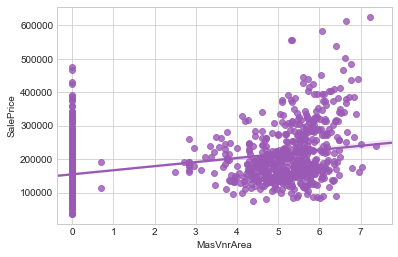

In [43]:
ax = sns.regplot(x="MasVnrArea", y="SalePrice", data=full_dataset[full_dataset['SalePrice'].notnull()])

In [44]:
full_dataset['BsmtHalfBath'].fillna(0,inplace=True)
full_dataset['BsmtFullBath'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtUnfSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF2'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF1'].fillna(0,inplace=True)
full_dataset['GarageArea'].fillna(0,inplace=True)
full_dataset['GarageCars'].fillna(0,inplace=True)

In [45]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
LogSalePrice    1459
SalePrice       1459
dtype: int64


In [46]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold
0,RL,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No Fireplace,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No MiscFeature,WD,Normal,60,7,5,2003,2003,2003.0,2,2008
1,RL,Pave,No Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No MiscFeature,WD,Normal,20,6,8,1976,1976,1976.0,5,2007
2,RL,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No MiscFeature,WD,Normal,60,7,5,2001,2002,2001.0,9,2008
3,RL,Pave,No Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,No Pool,No Fence,No MiscFeature,WD,Abnorml,70,7,5,1915,1970,1998.0,2,2006
4,RL,Pave,No Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No MiscFeature,WD,Normal,60,8,5,2000,2000,2000.0,12,2008


In [47]:
print(categorical_features)
ordinal_category.extend(['ExterQual', 'ExterCond','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC',
                         'OverallQual', 'OverallCond','BsmtQual','BsmtCond','BsmtFinType1',
                         'BsmtFinType2' ,'HeatingQC'])
categorical_features = [feature for feature in categorical_features if feature not in ordinal_category ]
len(categorical_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']


31

In [48]:
 
def plot_barplot(dataset,features,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)
    omit_features = ['Neighborhood', 'Condition1', 'Condition2','Exterior1st', 'Exterior2nd']
    features =[feature for feature in features if feature not in omit_features ]
    for i in range(0,len(features)):
        if ((features[i] != response_column ) and (features[i] not in omit_features)):
            ax = fig.add_subplot(3, 4,i + 1)
            sns.barplot(x=features[i], y=response_column, data=train_dataset)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
            if log:
                ax.set(xscale="log",yscale ="log")
            plt.tight_layout()
 
    plt.show()


In [49]:
def plot_boxplot(dataset,features,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)
    omit_features = ['Neighborhood', 'Condition1', 'Condition2','Exterior1st', 'Exterior2nd']
    features =[feature for feature in features if feature not in omit_features ]
    for i in range(0,len(features)):
        if ((features[i] != response_column ) and (features[i] not in omit_features)):
            ax = fig.add_subplot(3, 4,  i + 1)
            if log:
                ax.set(yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.boxplot(x=features[i], y=response_column, data=train_dataset)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
            plt.tight_layout()
 
    plt.show()

### Next Steps  turn categorical features in numerical  

In [50]:
final_categorical = [feature for feature in categorical_features if feature not in ordinal_category]

In [51]:
#full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, final_categorical, replace=True)

In [52]:
full_dataset[ordinal_category].head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,ExterQual,ExterCond,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,OverallQual,OverallCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC
0,60,7,5,2003,2003,2003.0,2,2008,Gd,TA,Gd,No Fireplace,TA,TA,No Pool,7,5,Gd,TA,GLQ,Unf,Ex
1,20,6,8,1976,1976,1976.0,5,2007,TA,TA,TA,TA,TA,TA,No Pool,6,8,Gd,TA,ALQ,Unf,Ex
2,60,7,5,2001,2002,2001.0,9,2008,Gd,TA,Gd,TA,TA,TA,No Pool,7,5,Gd,TA,GLQ,Unf,Ex
3,70,7,5,1915,1970,1998.0,2,2006,TA,TA,Gd,Gd,TA,TA,No Pool,7,5,TA,Gd,ALQ,Unf,Gd
4,60,8,5,2000,2000,2000.0,12,2008,Gd,TA,Gd,TA,TA,TA,No Pool,8,5,Gd,TA,GLQ,Unf,Ex


In [53]:
full_dataset['ExterQual'] = full_dataset['ExterQual'].str.upper().str.strip()
full_dataset['ExterCond'] =full_dataset['ExterCond'].str.upper().str.strip()
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].str.upper().str.strip()
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].str.upper().str.strip()
full_dataset['GarageQual'] =full_dataset['GarageQual'].str.upper().str.strip()
full_dataset['GarageCond']=full_dataset['GarageCond'].str.upper().str.strip()

full_dataset['PoolQC'] = full_dataset['PoolQC'].str.upper().str.strip()
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].str.upper().str.strip()
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].str.upper().str.strip()
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].str.upper().str.strip()
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].str.upper().str.strip()
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].str.upper().str.strip()
external_quality = full_dataset['ExterQual'].unique().tolist()
print(external_quality)
external_condition = full_dataset['ExterCond'].unique().tolist()
print(external_condition)
kitchen_quality = full_dataset['KitchenQual'].unique().tolist() 
print(kitchen_quality)
fireplace_quality = full_dataset['FireplaceQu'].unique().tolist()
print(fireplace_quality)
garage_quality =  full_dataset['GarageQual'].unique().tolist()
print(garage_quality)
garage_condition=  full_dataset['GarageCond'].unique().tolist()
print(garage_condition)
pool_quality =  full_dataset['PoolQC'].unique().tolist()
print(pool_quality)
basement_quality = full_dataset['BsmtQual'].unique().tolist()
print(basement_quality)
basement_condition = full_dataset['BsmtCond'].unique().tolist()
print(basement_condition)
heating_quality = full_dataset['HeatingQC'].unique().tolist()
print(heating_quality)
basement_finish_type1 = sorted(full_dataset['BsmtFinType1'].unique().tolist())
print(basement_finish_type1)
basement_finish_type2 = sorted(full_dataset['BsmtFinType2'].unique().tolist())
print(basement_finish_type2)

['GD', 'TA', 'EX', 'FA']
['TA', 'GD', 'FA', 'PO', 'EX']
['GD', 'TA', 'EX', 'FA']
['NO FIREPLACE', 'TA', 'GD', 'FA', 'EX', 'PO']
['TA', 'FA', 'GD', 'NO GARAGE', 'EX', 'PO']
['TA', 'FA', 'NO GARAGE', 'GD', 'PO', 'EX']
['NO POOL', 'EX', 'FA', 'GD']
['GD', 'TA', 'EX', 'NO BASEMENT', 'FA']
['TA', 'GD', 'NO BASEMENT', 'FA', 'PO']
['EX', 'GD', 'TA', 'FA', 'PO']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']


In [54]:
quality_converter = {'NA':0,'NO FIREPLACE':0,'NO POOL':0,'NO BASEMENT':0,'NO GARAGE':0,'PO':1, 'FA':2,'TA':3 ,'GD':4,'EX' :5}
full_dataset['ExterQual'] = full_dataset['ExterQual'].map(quality_converter)
full_dataset['ExterCond'] =full_dataset['ExterCond'].map(quality_converter)
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].map(quality_converter)
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].map(quality_converter)
full_dataset['GarageQual'] =full_dataset['GarageQual'].map(quality_converter)
full_dataset['PoolQC'] = full_dataset['PoolQC'].map(quality_converter)
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].map(quality_converter)
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].map(quality_converter)
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].map(quality_converter)
full_dataset['GarageCond'] =full_dataset['GarageCond'].map(quality_converter)

In [55]:
basement_finish_converter ={ 'NO BASEMENT':0,  'UNF':1, 'LWQ':2,'REC':3,'BLQ':4,'ALQ':5,'GLQ':6}
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].map(basement_finish_converter)
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].map(basement_finish_converter)

In [56]:
full_dataset["TotBath"] = full_dataset["FullBath"] + 0.5*full_dataset["HalfBath"] + full_dataset["BsmtFullBath"] + 0.5*full_dataset["BsmtHalfBath"]
full_dataset.drop(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"],axis=1,inplace=True)
full_dataset["TotArea"] = full_dataset["GrLivArea"] + full_dataset["TotalBsmtSF"]
full_dataset['TotalFloorSF'] = full_dataset['1stFlrSF'] + full_dataset['2ndFlrSF']
full_dataset.drop(['1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

In [57]:
garage_finish = full_dataset['GarageFinish'].unique().tolist()
full_dataset['GarageFinish'] = full_dataset['GarageFinish'].map(lambda x: garage_finish.index(x))
ordinal_category.append('GarageFinish')

In [58]:
groupby_neighborhood = train_dataset.groupby(by=['Neighborhood'])['SalePrice'].mean()
groupby_neighborhood 
groupby_neighborhood['Blmngtn']
#bins = [25, 50, 75]
#names = ['Cheap', 'Normal', 'Expensive'] 
#train_dataset['price_point'] = pd.cut(df.price, bins, labels=names)

194870.88235294117

In [59]:
full_dataset['TotalPorchSF'] = (full_dataset['OpenPorchSF'] + full_dataset['EnclosedPorch'] + 
                               full_dataset['3SsnPorch'] + full_dataset['ScreenPorch'])
#full_dataset['HasBasement'] = full_dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
#full_dataset['HasGarage'] = full_dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#full_dataset['HasPool'] = full_dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
#full_dataset['WasRemodeled'] = (full_dataset['YearRemodAdd'] != full_dataset['YearBuilt']).astype(np.int64)
#full_dataset['IsNew'] = (full_dataset['YearBuilt'] > 2000).astype(np.int64)
#full_dataset['HasPorch'] = full_dataset['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)
#full_dataset['WasCompleted'] = (full_dataset['SaleCondition ']!= 'Partial').astype(np.int64)
full_dataset.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

In [60]:
final_categorical = [feature for feature in categorical_features if feature not in ordinal_category]

In [61]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
LogSalePrice    1459
SalePrice       1459
dtype: int64


In [62]:
full_dataset[ordinal_category].head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,ExterQual,ExterCond,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,OverallQual,OverallCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,GarageFinish
0,60,7,5,2003,2003,2003.0,2,2008,4,3,4,0,3,3,0,7,5,4,3,6,1,5,0
1,20,6,8,1976,1976,1976.0,5,2007,3,3,3,3,3,3,0,6,8,4,3,5,1,5,0
2,60,7,5,2001,2002,2001.0,9,2008,4,3,4,3,3,3,0,7,5,4,3,6,1,5,0
3,70,7,5,1915,1970,1998.0,2,2006,3,3,4,4,3,3,0,7,5,3,4,5,1,4,1
4,60,8,5,2000,2000,2000.0,12,2008,4,3,4,3,3,3,0,8,5,4,3,6,1,5,0


In [63]:
irrelevant_features  =['Utilities','RoofMatl','Exterior1st','Exterior2nd','RoofMatl','RoofStyle']
final_categorical = [feature for feature in final_categorical if feature not in irrelevant_features ]
full_dataset.drop(irrelevant_features,inplace=True,axis=1)
extra_Features =['HasBasement','HasGarage','HasPool','WasRemodeled','IsNew','HasPorch']

In [64]:
final_non_count = [feature  for feature in full_dataset.columns.values if feature not in final_categorical+ordinal_category+['Id','SalePrice','LogSalePrice'] ]
final_non_count

['BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Fireplaces',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'PoolArea',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'TotBath',
 'TotArea',
 'TotalFloorSF',
 'TotalPorchSF']

In [65]:
from datatools.customtransformers import StdScaleTransformer
std_scaler = StdScaleTransformer(final_non_count)
full_dataset =std_scaler.fit_transform(full_dataset)

In [66]:
full_dataset.head()

,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,Foundation,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,SaleCondition,SalePrice,SaleType,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,LogSalePrice,TotBath,TotArea,TotalFloorSF,TotalPorchSF
0,No Alley,0.1710,1Fam,3,No,0.6054,-0.2932,6,1,4,-0.9335,Y,Norm,Norm,SBrkr,3,4,No Fence,0,-0.9245,PConc,Typ,0.3541,0.3090,3,0,3,Attchd,2003.0,0.4352,GasA,5,2Story,1,-0.2078,4,Lvl,Gtl,-0.2157,Inside,-0.1858,Reg,-0.1013,60,RL,1.2256,BrkFace,No MiscFeature,-0.0897,2,CollgCr,5,7,Y,-0.0575,0,Normal,208500.0,WD,Pave,0.9953,-0.4486,-0.7396,2003,2003,2008,12.2477,1.5952,0.0280,0.4470,-0.2607
1,No Alley,0.1710,1Fam,3,Gd,1.2196,-0.2932,5,1,4,-0.6287,Y,Feedr,Norm,SBrkr,3,3,No Fence,3,0.6287,CBlock,Typ,-0.0560,0.3090,3,0,3,Attchd,1976.0,-0.4770,GasA,5,1Story,2,-0.2078,3,Lvl,Gtl,-0.0684,FR2,0.5063,Reg,-0.1013,20,RL,-0.7927,None,No MiscFeature,-0.0897,5,Veenker,8,6,Y,-0.0575,0,Normal,181500.0,WD,Pave,-0.2853,0.4999,1.6174,1976,1976,2007,12.1090,0.3534,-0.0262,-0.4698,-0.8270
2,No Alley,0.1710,1Fam,3,Mn,0.1085,-0.2932,6,1,4,-0.2876,Y,Norm,Norm,SBrkr,3,4,No Fence,3,0.6287,PConc,Typ,0.6337,0.3090,3,0,3,Attchd,2001.0,0.5899,GasA,5,2Story,3,-0.2078,4,Lvl,Gtl,0.1430,Inside,-0.0474,IR1,-0.1013,60,RL,1.1532,BrkFace,No MiscFeature,-0.0897,9,CollgCr,5,7,Y,-0.0575,0,Normal,223500.0,WD,Pave,-0.2853,-0.2991,-0.7396,2001,2002,2008,12.3172,1.5952,0.2089,0.6025,-0.4371
3,No Alley,0.1710,1Fam,4,No,-0.5012,-0.2932,5,1,3,-0.0465,Y,Norm,Norm,SBrkr,3,3,No Fence,4,0.6287,BrkTil,Typ,0.7921,1.6221,3,1,3,Detchd,1998.0,0.4494,GasA,4,2Story,4,-0.2078,4,Lvl,Gtl,-0.0748,Corner,-0.4165,IR1,-0.1013,70,RL,-0.7927,None,No MiscFeature,-0.0897,2,Crawfor,5,7,Y,-0.0575,0,Abnorml,140000.0,WD,Pave,0.3550,-0.6822,-0.7396,1915,1970,2006,11.8494,-0.2675,-0.0921,0.4613,2.0227
4,No Alley,1.3867,1Fam,3,Av,0.4902,-0.2932,6,1,4,-0.1602,Y,Norm,Norm,SBrkr,3,4,No Fence,3,0.6287,PConc,Typ,1.6961,1.6221,3,0,3,Attchd,2000.0,1.4287,GasA,5,2Story,5,-0.2078,4,Lvl,Gtl,0.5287,FR2,0.6908,IR1,-0.1013,60,RL,1.4462,BrkFace,No MiscFeature,-0.0897,12,NoRidge,5,8,Y,-0.0575,0,Normal,250000.0,WD,Pave,1.6356,0.2266,0.7790,2000,2000,2008,12.4292,1.5952,1.0318,1.4457,-0.0472


In [67]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, final_categorical, replace=True)

In [68]:
all_columns  = full_dataset.columns.values.tolist()
len(all_columns)

197

In [69]:
Checkpoint

NameError: name 'Checkpoint' is not defined

In [70]:
def plot_heatmap(input_dataset,feature_columns):
    sns.set(font_scale=1.5)
    cm=input_dataset[feature_columns].corr('pearson')
    mask = np.array(cm)
    mask[np.tril_indices_from(mask)] = False
    f, ax = plt.subplots(figsize=(30,25))
    hm = sns.heatmap(cm,cbar=True,mask = mask,annot=True,square=True,annot_kws={'size': 7},
                     yticklabels=feature_columns,xticklabels=feature_columns)
    plt.show()
#plot_heatmap(heatmap_data,all_columns)

In [71]:
heatmap_data =full_dataset[full_dataset['SalePrice'].notnull()][all_columns]
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.85
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['SalePrice','LogSalePrice']]
to_drop = to_drop + ['PoolArea','MiscVal']

In [72]:
correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear

,drop_feature,corr_feature,corr_value
0,Fireplaces,FireplaceQu,0.8650
1,GarageCars,GarageArea,0.8869
2,GarageQual,GarageCond,0.9592
3,GarageYrBlt,GarageCond,0.9494
4,GarageYrBlt,GarageQual,0.9466
5,PoolQC,PoolArea,0.9310
6,TotArea,GrLivArea,0.8672
7,TotalFloorSF,GrLivArea,0.9952
8,TotalFloorSF,TotArea,0.8679
9,CentralAir=Y,CentralAir=N,-1.0000


In [73]:
highly_correlated_features = heatmap_data.columns[corr_matrix['SalePrice'].abs() > .18]
#highly_correlated_features.tolist()
len(highly_correlated_features)
overlapping = set(highly_correlated_features) & set(to_drop)
print(overlapping)
final_drop =['GarageQual','GarageYrBlt','TotalFloorSF']
selected_features = [feature for feature in highly_correlated_features if feature not in final_drop  ]
print(len(selected_features))

{'Electrical=SBrkr', 'TotArea', 'GarageCars', 'PavedDrive=Y', 'GarageType=No Garage', 'MasVnrType=None', 'Fireplaces', 'GarageQual', 'LotShape=Reg', 'TotalFloorSF', 'GarageYrBlt', 'SaleType=New', 'CentralAir=Y'}
61


In [74]:
full_dataset.head()

,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,ExterCond,ExterQual,FireplaceQu,Fireplaces,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HeatingQC,Id,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OverallCond,OverallQual,PoolArea,PoolQC,SalePrice,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,LogSalePrice,TotBath,TotArea,TotalFloorSF,TotalPorchSF,Alley=Grvl,Alley=No Alley,Alley=Pave,BldgType=1Fam,...,MiscFeature=Gar2,MiscFeature=No MiscFeature,MiscFeature=Othr,MiscFeature=Shed,MiscFeature=TenC,Neighborhood=Blmngtn,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=IDOTRR,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=Somerst,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker,PavedDrive=N,PavedDrive=P,PavedDrive=Y,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave
0,0.1710,3,0.6054,-0.2932,6,1,4,-0.9335,3,4,0,-0.9245,0.3541,0.3090,3,0,3,2003.0,0.4352,5,1,-0.2078,4,-0.2157,-0.1858,-0.1013,60,1.2256,-0.0897,2,5,7,-0.0575,0,208500.0,0.9953,-0.4486,-0.7396,2003,2003,2008,12.2477,1.5952,0.0280,0.4470,-0.2607,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.1710,3,1.2196,-0.2932,5,1,4,-0.6287,3,3,3,0.6287,-0.0560,0.3090,3,0,3,1976.0,-0.4770,5,2,-0.2078,3,-0.0684,0.5063,-0.1013,20,-0.7927,-0.0897,5,8,6,-0.0575,0,181500.0,-0.2853,0.4999,1.6174,1976,1976,2007,12.1090,0.3534,-0.0262,-0.4698,-0.8270,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.1710,3,0.1085,-0.2932,6,1,4,-0.2876,3,4,3,0.6287,0.6337,0.3090,3,0,3,2001.0,0.5899,5,3,-0.2078,4,0.1430,-0.0474,-0.1013,60,1.1532,-0.0897,9,5,7,-0.0575,0,223500.0,-0.2853,-0.2991,-0.7396,2001,2002,2008,12.3172,1.5952,0.2089,0.6025,-0.4371,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.1710,4,-0.5012,-0.2932,5,1,3,-0.0465,3,3,4,0.6287,0.7921,1.6221,3,1,3,1998.0,0.4494,4,4,-0.2078,4,-0.0748,-0.4165,-0.1013,70,-0.7927,-0.0897,2,5,7,-0.0575,0,140000.0,0.3550,-0.6822,-0.7396,1915,1970,2006,11.8494,-0.2675,-0.0921,0.4613,2.0227,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.3867,3,0.4902,-0.2932,6,1,4,-0.1602,3,4,3,0.6287,1.6961,1.6221,3,0,3,2000.0,1.4287,5,5,-0.2078,4,0.5287,0.6908,-0.1013,60,1.4462,-0.0897,12,5,8,-0.0575,0,250000.0,1.6356,0.2266,0.7790,2000,2000,2008,12.4292,1.5952,1.0318,1.4457,-0.0472,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [75]:
select_features = [feature for feature in full_dataset.columns if feature not in to_drop]

In [76]:
full_dataset = full_dataset[select_features]

In [77]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset.head()

,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,ExterCond,ExterQual,FireplaceQu,GarageArea,GarageCond,GarageFinish,GrLivArea,HeatingQC,Id,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OverallCond,OverallQual,SalePrice,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,LogSalePrice,TotBath,TotalPorchSF,Alley=Grvl,Alley=No Alley,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtExposure=Av,BsmtExposure=Gd,BsmtExposure=Mn,BsmtExposure=No,BsmtExposure=No Basement,...,MSZoning=RH,MSZoning=RL,MSZoning=RM,MasVnrType=BrkCmn,MasVnrType=BrkFace,MasVnrType=Stone,MiscFeature=No MiscFeature,MiscFeature=Othr,MiscFeature=TenC,Neighborhood=Blmngtn,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=IDOTRR,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker,PavedDrive=N,PavedDrive=P,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=Oth,SaleType=WD,Street=Grvl
0,0.1710,3,0.6054,-0.2932,6,1,4,-0.9335,3,4,0,0.3541,3,0,0.4352,5,1,-0.2078,4,-0.2157,-0.1858,-0.1013,60,1.2256,2,5,7,208500.0,0.9953,-0.4486,-0.7396,2003,2003,2008,12.2477,1.5952,-0.2607,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.1710,3,1.2196,-0.2932,5,1,4,-0.6287,3,3,3,-0.0560,3,0,-0.4770,5,2,-0.2078,3,-0.0684,0.5063,-0.1013,20,-0.7927,5,8,6,181500.0,-0.2853,0.4999,1.6174,1976,1976,2007,12.1090,0.3534,-0.8270,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.1710,3,0.1085,-0.2932,6,1,4,-0.2876,3,4,3,0.6337,3,0,0.5899,5,3,-0.2078,4,0.1430,-0.0474,-0.1013,60,1.1532,9,5,7,223500.0,-0.2853,-0.2991,-0.7396,2001,2002,2008,12.3172,1.5952,-0.4371,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.1710,4,-0.5012,-0.2932,5,1,3,-0.0465,3,3,4,0.7921,3,1,0.4494,4,4,-0.2078,4,-0.0748,-0.4165,-0.1013,70,-0.7927,2,5,7,140000.0,0.3550,-0.6822,-0.7396,1915,1970,2006,11.8494,-0.2675,2.0227,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.3867,3,0.4902,-0.2932,6,1,4,-0.1602,3,4,3,1.6961,3,0,1.4287,5,5,-0.2078,4,0.5287,0.6908,-0.1013,60,1.4462,12,5,8,250000.0,1.6356,0.2266,0.7790,2000,2000,2008,12.4292,1.5952,-0.0472,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [78]:
train_features =train_dataset.drop(['SalePrice','LogSalePrice'],axis=1)
train_target = train_dataset['LogSalePrice']


In [79]:
features =train_features.columns.tolist()
check_null(train_features)

<=================================== Dataset null value count ===================================>
Series([], dtype: int64)


In [80]:
selected_features.remove('SalePrice')
selected_features.remove('LogSalePrice')

In [81]:
train_Id  = full_dataset[full_dataset['SalePrice'].notnull()]["Id"]
test_Id = full_dataset[full_dataset['SalePrice'].isnull()]["Id"]
full_dataset.drop(['Id'],axis=1,inplace=True)


In [82]:
train_X = full_dataset[full_dataset['SalePrice'].notnull()]#[selected_features]
test_X = full_dataset[full_dataset['SalePrice'].isnull()]  #[selected_features]
train_y= full_dataset[full_dataset['LogSalePrice'].notnull()]['LogSalePrice']
train_X.drop(['SalePrice','LogSalePrice'],axis=1,inplace=True)


D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [83]:
test_X.drop(['SalePrice','LogSalePrice'],axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [84]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 17
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)

(1456, 173)
(1459, 173)


In [85]:
def best_fit_search(grid,train_X,train_y):
    
    grid.fit(X=train_X,y=train_y)
    print(grid.best_score_)
    print(grid.best_params_)
    best_model =grid.best_estimator_
    best_model.fit(X = X_trainmodel,y = y_trainmodel)
    y_pred_val= best_model.predict(X= X_val)
    print ("RMSLE Value: ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
    train_sizes, train_scores, validation_scores = learning_curve(best_model, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return best_model

RMSLE Value :  0.30239938498574476


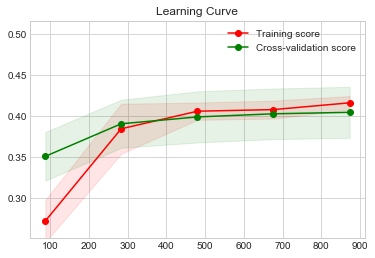

In [86]:
from sklearn.linear_model import ElasticNet
elnet_regr = ElasticNet(random_state=0)
elnet_regr.fit(X = X_trainmodel,y = y_trainmodel)
y_pred_val= elnet_regr.predict(X= X_val)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(elnet_regr, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)

0.9130430046553274
{'alpha': 0.001, 'l1_ratio': 0.9, 'max_iter': 10000}
RMSLE Value:  0.11471277551024797


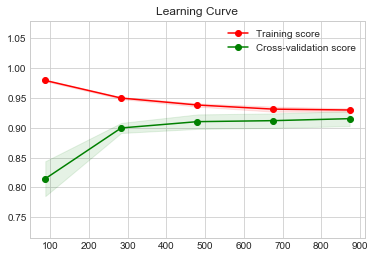

In [87]:
param_grid = {'alpha': np.logspace(-4, -1, 10),
              'l1_ratio': [0.01, .1, .5, .9, .98, 1],
              'max_iter':[10000]
                 }

grid = GridSearchCV(estimator=elnet_regr, param_grid=param_grid, n_jobs=-1)
best_model =best_fit_search(grid,X_trainmodel, y_trainmodel)

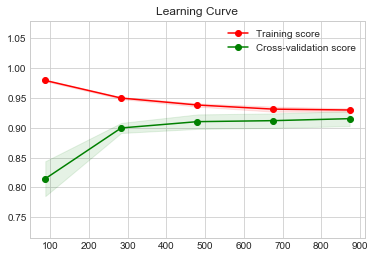

RMSLE Value : 0.11471277551024797


In [88]:
train_sizes, train_scores, validation_scores = learning_curve(best_model, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)
y_pred_val= best_model.predict(X= X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

In [ ]:
Checkpoint

In [89]:
best_model

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [90]:
from sklearn.linear_model import ElasticNetCV
elnet_cv = ElasticNetCV(cv=5, random_state=0,max_iter =10000,alphas= np.logspace(-4, -1, 10),l1_ratio=0.5)
print(elnet_cv)
elnet_cv.fit(X_trainmodel, y_trainmodel)
y_pred_val= elnet_cv.predict(X= X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))


ElasticNetCV(alphas=array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)
RMSLE Value : 0.11278490655093269


In [91]:
print("Number of Iteration:{0}".format(elnet_cv.n_iter_))
print("Alphas computed :{0}".format(elnet_cv.alphas))
y_pred_result = best_model.predict(X=test_X)

Number of Iteration:169
Alphas computed :[0.0001 0.0002 0.0005 0.001  0.0022 0.0046 0.01   0.0215 0.0464 0.1   ]


In [92]:
y_pred_result = elnet_cv.predict(X=test_X)

In [93]:
y_pred_result = np.exp(y_pred_result)-1
print(y_pred_result[1:10])
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="output/submission_housing_elastic"+timestamp+"_out.csv"
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": y_pred_result
    })
submission.to_csv(filename, index=False)


[158425.4898 177913.211  202132.6315 186080.5796 172238.4499 181732.6204
 162794.224  195567.6009 117474.7842]


### Kaggle report
#### Your submission scored 0.12254, which is an improvement of your previous score of 0.12316. 

#### Next steps  
##### Feature selection